In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import tqdm
import numpy as np
import numba
import dask

In [2]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

In [3]:
test_coords = np.random.rand(100000, 2)

In [4]:
%timeit img = render(test_coords, 100)
img = render(test_coords, 100)

197 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


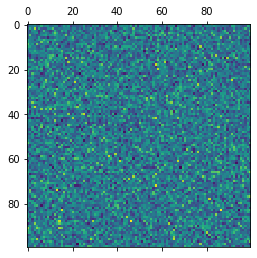

In [5]:
plt.matshow(img)

In [6]:
jit_render = numba.jit(render, nogil=True, nopython=True)

In [7]:
%timeit img2 = jit_render(test_coords, 100)
img2 = jit_render(test_coords, 100)

254 µs ± 5.99 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
np.array_equal(img2, img)

True

In [9]:
# test_coords_list = [np.random.rand(100000000, 2) for i in range(16)]
test_coords_list = np.random.rand(16, 100000000, 2)

In [10]:
%time linear_compute = [jit_render(tc, 100) for tc in (test_coords_list)]

Wall time: 6.02 s


In [11]:
%time dask_compute = dask.compute([dask.delayed(jit_render)(tc, 100) for tc in test_coords_list], num_workers=16)

Wall time: 625 ms


In [2]:
%load_ext watermark
%watermark
print()
%watermark -p dask,numpy,numba

2019-07-02T11:42:10-04:00

CPython 3.7.3
IPython 7.5.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 48
interpreter: 64bit

dask 1.2.2
numpy 1.16.4
numba 0.44.1


In [10]:
# import os
# import numpy as np
# import numba
# import dask

# CPU_COUNT = os.cpu_count()

def render_internal(size, mag):
    """mag is the magnification to apply
    generate coordinates internally
    """
    coords = np.random.rand(size, 2)
    img = np.zeros((mag, mag), dtype=np.int64)
    for i in range(size):
#         y0 = coords[0, i]
#         x0 = coords[1, i]
#         y1 = int(y0 * mag)
#         x1 = int(x0 * mag)
        m = 1
        img[0, 0] += m

jit_render_internal = numba.jit(render_internal, nogil=True, nopython=True)

args = 10000000, 10

print("Linear time:")
%time linear_compute = [jit_render_internal(*args) for i in range(CPU_COUNT)]

delayed_jit_render_internal = dask.delayed(jit_render_internal)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="threads")

print()
print("Processes time:")
%time dask_compute_processes = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="processes")
        

Linear time:
Wall time: 13.6 s

Threads time:
Wall time: 6.22 s

Processes time:
Wall time: 7.95 s


In [6]:
import os
import numpy as np
import numba
import dask

CPU_COUNT = os.cpu_count()

def render_internal(size, mag):
    """mag is the magnification to apply
    generate coordinates internally
    """
    coords = np.zeros((size, 2))
    img = np.zeros((mag, mag), dtype=np.int64)
    for i in range(size):
#         y0 = np.random.rand() * mag
#         x0 = np.random.rand() * mag
        
        y0 = 0.0
        x0 = 0.0
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

jit_render_internal = numba.jit(render_internal, nogil=True, nopython=True)

args = 1000000, 10

print("Linear time:")
%time linear_compute = [jit_render_internal(*args) for i in range(CPU_COUNT)]

delayed_jit_render_internal = dask.delayed(jit_render_internal)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="threads")

print()
print("Processes time:")
%time dask_compute_processes = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="processes")
        

Linear time:
Wall time: 833 ms

Threads time:
Wall time: 649 ms

Processes time:
Wall time: 7.24 s


In [8]:
%%time
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Start the load operations and mark each future with its URL
    future_to_data = [executor.submit(jit_render_internal, *args) for i in range(48)]
    result = [future.result() for future in future_to_data]

Wall time: 10.7 s


In [10]:
%%time
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Start the load operations and mark each future with its URL
    future_to_data = [executor.submit(jit_render_internal, *args) for i in range(48)]
    result = [future.result() for future in future_to_data]

Wall time: 4.66 s


In [12]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = np.random.rand(1000000, 2), 10

jit_render(*args)

print("Linear time:")
%time linear_compute = [jit_render(*args) for i in range(CPU_COUNT)]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*args) for i in range(CPU_COUNT)], scheduler="threads")

Linear time:
Wall time: 137 ms

Threads time:
Wall time: 19 ms


In [3]:
import os
CPU_COUNT = os.cpu_count()

In [7]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0) // 2 + 1
        x1 = int(x0) // 2 + 1
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = np.random.rand(1000000, 2), 10

jit_render(*args)

print("Linear time:")
%time linear_compute = [jit_render(*args) for i in range(CPU_COUNT)]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*args) for i in range(CPU_COUNT)], scheduler="threads")

Linear time:
Wall time: 287 ms

Threads time:
Wall time: 36 ms


In [10]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0, x0 = coords[i] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = np.random.rand(1000000, 2), 10

jit_render(*args)

print("Linear time:")
%time linear_compute = [jit_render(*args) for i in range(CPU_COUNT)]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*args) for i in range(CPU_COUNT)], scheduler="threads")

Linear time:
Wall time: 6.85 s

Threads time:
Wall time: 11.4 s
